# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_transaction = pd.read_csv('train_transaction.csv')
train_identity    = pd.read_csv('train_identity.csv')
test_transaction  = pd.read_csv('test_transaction.csv')
test_identity     = pd.read_csv('test_identity.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("train_transaction shape:", train_transaction.shape)
print("train_identity shape:", train_identity.shape)
print("test_transaction shape:", test_transaction.shape)
print("test_identity shape:", test_identity.shape)
print("sample_submission shape:", sample_submission.shape)

df_train = pd.merge(train_transaction, train_identity,on='TransactionID',how='left')
df_test = pd.merge(test_transaction,test_identity,on='TransactionID',how='left')

print("df_train shape:", df_train.shape)
print("df_test shape:", df_test.shape)


train_transaction shape: (417559, 394)
train_identity shape: (110666, 41)
test_transaction shape: (172981, 393)
test_identity shape: (33567, 41)
sample_submission shape: (172981, 2)
df_train shape: (417559, 434)
df_test shape: (172981, 433)


# **Краткое описание данных**

In [5]:
print("Информация о df_train:")
df_train.info()
print("\nИнформация о df_test:")
df_test.info()

Информация о df_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.4+ GB

Информация о df_test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 571.4+ MB


Проверка дубликатов

In [6]:
duplicates_train = df_train.duplicated().sum()
duplicates_test = df_test.duplicated().sum()

print(f"Число дубликатов в df_train: {duplicates_train}")
print(f"Число дубликатов в df_test: {duplicates_test}")

Число дубликатов в df_train: 0
Число дубликатов в df_test: 0


Анализ пропусков

In [7]:
missing_train = df_train.isna().sum().sort_values(ascending=False)
missing_test = df_test.isna().sum().sort_values(ascending=False)

print("TOP 10 признаков с наибольшим числом пропусков в train:")
print(missing_train.head(10))

print("\nTOP 10 признаков с наибольшим числом пропусков в test:")
print(missing_test.head(10))

# Можно также посчитать процент пропусков:
missing_ratio_train = (missing_train / len(df_train)) * 100
print("\nTOP 10 (доля пропусков в % в train):")
print(missing_ratio_train.head(10))

TOP 10 признаков с наибольшим числом пропусков в train:
id_24    413935
id_25    413629
id_08    413614
id_07    413614
id_26    413611
id_21    413609
id_27    413605
id_23    413605
id_22    413605
D7       390613
dtype: int64

TOP 10 признаков с наибольшим числом пропусков в test:
id_24    171858
id_25    171779
id_21    171772
id_08    171771
id_07    171771
id_27    171766
id_26    171766
id_22    171766
id_23    171766
dist2    164640
dtype: int64

TOP 10 (доля пропусков в % в train):
id_24    99.132099
id_25    99.058816
id_08    99.055223
id_07    99.055223
id_26    99.054505
id_21    99.054026
id_27    99.053068
id_23    99.053068
id_22    99.053068
D7       93.546780
dtype: float64


Общее статистическое описание числовых признаков

In [8]:
print("Описание числовых признаков df_train:")
print(df_train.describe())

print("\nОписание числовых признаков df_test:")
print(df_test.describe())

Описание числовых признаков df_train:
       TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   4.175590e+05  417559.000000   4.175590e+05   417559.000000   
mean    3.195779e+06       0.035255   4.976936e+06      134.666566   
std     1.205390e+05       0.184424   3.099220e+06      238.166118   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.091390e+06       0.000000   2.072820e+06       42.950000   
50%     3.195779e+06       0.000000   4.822648e+06       68.950000   
75%     3.300168e+06       0.000000   7.786364e+06      125.000000   
max     3.404558e+06       1.000000   1.054080e+07    31937.391000   

               card1          card2          card3          card5  \
count  417559.000000  410996.000000  416738.000000  414578.000000   
mean     9865.320371     363.474253     153.347864     199.687439   
std      4900.674210     158.146603      11.566162      40.783018   
min      1000.000000     100.000000     100.000000     

Список категориальных и числовых признаков

In [9]:
categorical_cols = df_train.select_dtypes(include=['object']).columns.to_list()
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.to_list()

print("Категориальные колонки в df_train:", categorical_cols)
print("Числовые колонки в df_train:", numerical_cols)

Категориальные колонки в df_train: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
Числовые колонки в df_train: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49'

Краткий взгляд на целевую переменную (isFraud)

In [10]:
if 'isFraud' in df_train.columns:
    print("\nРаспределение целевой переменной (isFraud):")
    print(df_train['isFraud'].value_counts(dropna=False))


Распределение целевой переменной (isFraud):
isFraud
0    402838
1     14721
Name: count, dtype: int64


Смотрим на уникальные значения некоторых важных категориальных признаков

In [11]:
important_cats = ['ProductCD', 'card4', 'card6', 'DeviceType']
for col in important_cats:
    if col in df_train.columns:
        print(f"\nПризнак {col}, уникальные категории (train):")
        print(df_train[col].value_counts(dropna=False).head(10))


Признак ProductCD, уникальные категории (train):
ProductCD
W    301297
C     50474
R     30304
H     28216
S      7268
Name: count, dtype: int64

Признак card4, уникальные категории (train):
card4
visa                272753
mastercard          132403
american express      6765
discover              4809
NaN                    829
Name: count, dtype: int64

Признак card6, уникальные категории (train):
card6
debit              306554
credit             110134
NaN                   826
debit or credit        30
charge card            15
Name: count, dtype: int64

Признак DeviceType, уникальные категории (train):
DeviceType
NaN        309435
desktop     66324
mobile      41800
Name: count, dtype: int64


 Анализ возможных выбросов

In [12]:
if 'TransactionAmt' in df_train.columns:
    Q1 = df_train['TransactionAmt'].quantile(0.25)
    Q3 = df_train['TransactionAmt'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_train[(df_train['TransactionAmt'] < lower_bound) | 
                        (df_train['TransactionAmt'] > upper_bound)]

# **Обработка значений**

Удаляем признаки с > 90% пропусков

In [13]:
drop_threshold = 0.90
cols_to_drop = []
for col in df_train.columns:
    if df_train[col].isna().mean() > drop_threshold:
        cols_to_drop.append(col)

print(f"Колонки для удаления (доля NaN > {drop_threshold*100}%):")
print(cols_to_drop)

df_train.drop(columns=cols_to_drop, inplace=True, errors='ignore')
df_test.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print("После удаления колонки df_train.shape:", df_train.shape)
print("После удаления колонки df_test.shape:", df_test.shape)


Колонки для удаления (доля NaN > 90.0%):
['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
После удаления колонки df_train.shape: (417559, 422)
После удаления колонки df_test.shape: (172981, 421)


Заполняем NaN в категориальных признаках 'Unknown'

In [14]:
cat_cols = df_train.select_dtypes(include='object').columns.tolist()
cat_cols_test = df_test.select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    df_train[col].fillna('Unknown', inplace=True)

for col in cat_cols_test:
    df_test[col].fillna('Unknown', inplace=True)

Группируем редкие категории в 'Other'

In [15]:
def group_rare_categories(df, col, min_count=500, replace_val='Other'):
    freq = df[col].value_counts()
    major_cats = freq[freq >= min_count].index
    df[col] = df[col].where(df[col].isin(major_cats), replace_val)

for col in ['P_emaildomain', 'R_emaildomain']:
    if col in df_train.columns:
        group_rare_categories(df_train, col, min_count=500)

for col in ['P_emaildomain', 'R_emaildomain']:
    if col in df_test.columns and col in df_train.columns:
        major_cats_train = df_train[col].unique()
        df_test[col] = df_test[col].where(df_test[col].isin(major_cats_train), 'Other')


Обработка выбросов

In [16]:
clip_amt = False  

if clip_amt and ('TransactionAmt' in df_train.columns):
    Q1 = df_train['TransactionAmt'].quantile(0.25)
    Q3 = df_train['TransactionAmt'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_train['TransactionAmt'] = df_train['TransactionAmt'].clip(lower, upper)
    df_test['TransactionAmt'] = df_test['TransactionAmt'].clip(lower, upper)

# **Визуализация:**

Распределение целевой переменной

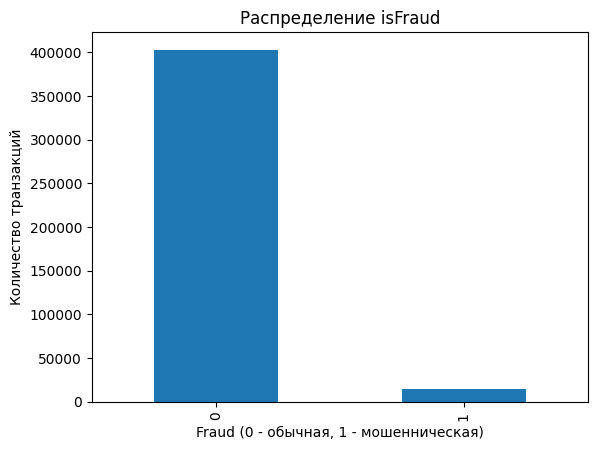

In [17]:
df_train['isFraud'].value_counts().plot(kind='bar')
plt.title("Распределение isFraud")
plt.xlabel("Fraud (0 - обычная, 1 - мошенническая)")
plt.ylabel("Количество транзакций")
plt.show()


Гистограмма TransactionAmt

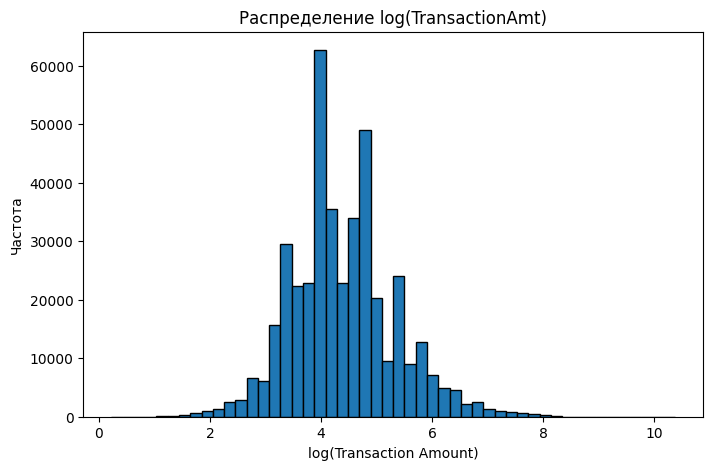

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
plt.hist(np.log1p(df_train['TransactionAmt']), bins=50, edgecolor='black')
plt.title("Распределение log(TransactionAmt)")
plt.xlabel("log(Transaction Amount)")
plt.ylabel("Частота")
plt.show()


Большинство транзакций совершаются на суммы ~50 и ~100 USD, а редкие крупные платежи (>200 USD) могут быть выбросами.

Сравнение распределения признаков для мошеннических (isFraud=1) и обычных (isFraud=0) транзакций.

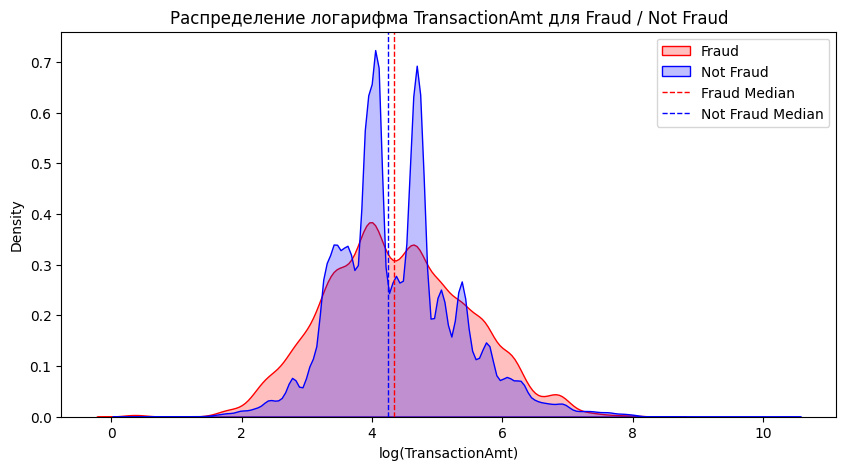

In [19]:
import seaborn as sns

plt.figure(figsize=(10, 5))

fraud_amounts = np.log1p(df_train[df_train['isFraud'] == 1]['TransactionAmt'])
not_fraud_amounts = np.log1p(df_train[df_train['isFraud'] == 0]['TransactionAmt'])

sns.kdeplot(fraud_amounts, label='Fraud', fill=True, color='red', common_norm=False)
sns.kdeplot(not_fraud_amounts, label='Not Fraud', fill=True, color='blue', common_norm=False)

plt.axvline(fraud_amounts.median(), color='red', linestyle='dashed', linewidth=1, label="Fraud Median")
plt.axvline(not_fraud_amounts.median(), color='blue', linestyle='dashed', linewidth=1, label="Not Fraud Median")

plt.title('Распределение логарифма TransactionAmt для Fraud / Not Fraud')
plt.xlabel('log(TransactionAmt)')
plt.ylabel('Density')
plt.legend()
plt.show()



 Мошеннические транзакции в среднем немного крупнее и имеют более равномерное распределение, тогда как обычные пользователи чаще проводят платежи фиксированной суммы (видно по буграм)

Распределение транзакций в течении дня

Мошеннические (Fraud) и обычные (Not Fraud) транзакции следуют схожему суточному паттерну — активность минимальна утром (~5-10 часов) и максимальна вечером (~18-23 часов)

Анализ временных признаков более детально (дни недели)

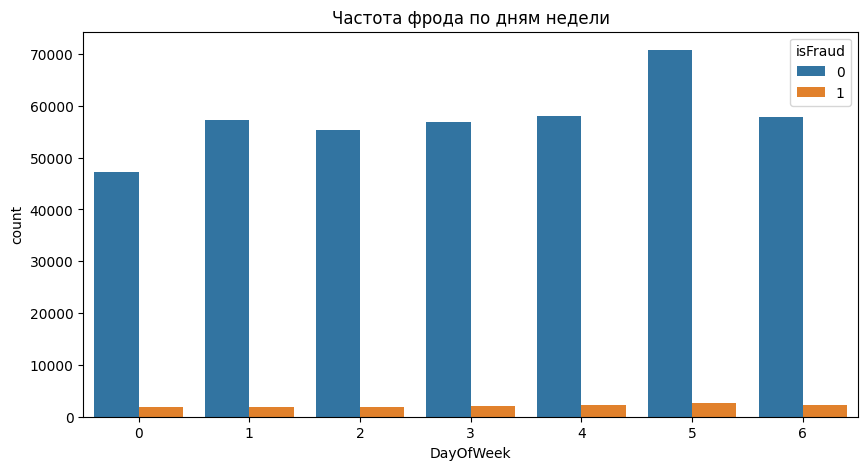

In [20]:
df_train['DayOfWeek'] = ((df_train['TransactionDT'] // 86400) + 4) % 7  
df_test['DayOfWeek'] = ((df_test['TransactionDT'] // 86400) + 4) % 7

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(
    data=df_train, 
    x='DayOfWeek', 
    hue='isFraud'
)
plt.title("Частота фрода по дням недели")
plt.show()


Можно увидеть что мошенические транзакции имеют равномерное распределение по дням недели, в субботу происходит больше транзакций чем обычно

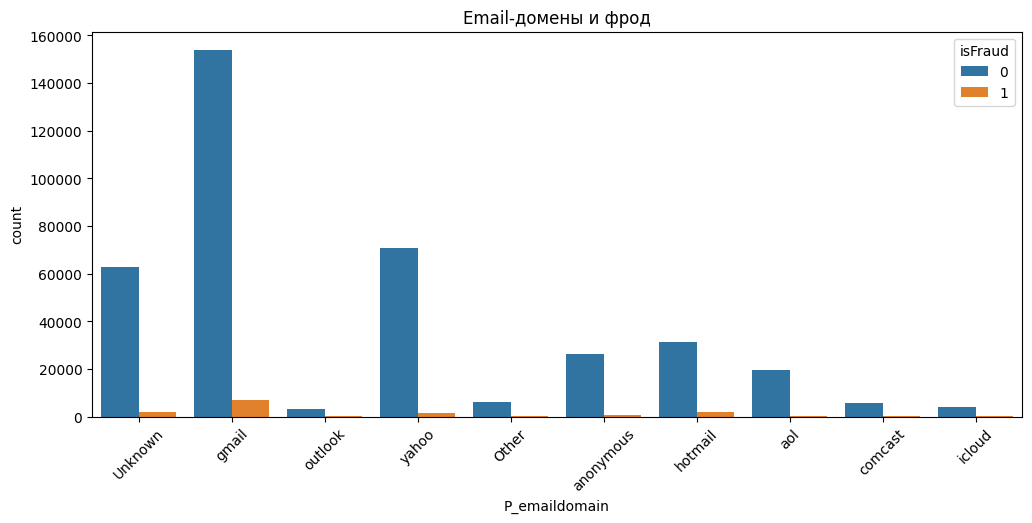

In [21]:
df_train['P_emaildomain'] = df_train['P_emaildomain'].apply(lambda x: x.split('.')[0] if pd.notna(x) else 'Unknown')

plt.figure(figsize=(12, 5))
top_domains = df_train['P_emaildomain'].value_counts().index[:10]
sns.countplot(data=df_train[df_train['P_emaildomain'].isin(top_domains)], x='P_emaildomain', hue='isFraud')
plt.xticks(rotation=45)
plt.title('Email-домены и фрод')
plt.show()


Большинство пользователей используют Gmail, Yahoo и Hotmail, но фрод встречается во всех доменах в небольших количествах


# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

Заполняем числовые пропуски (медианой)

In [ ]:
num_cols_train = df_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols_test = df_test.select_dtypes(include=[np.number]).columns.tolist()

if 'isFraud' in num_cols_train:
    num_cols_train.remove('isFraud')

for col in num_cols_train:
    median_val = df_train[col].median()
    df_train[col].fillna(median_val, inplace=True)

for col in num_cols_test:
    if col in df_test.columns:
        median_val = df_test[col].median()
        df_test[col].fillna(median_val, inplace=True)



Кодирование категориальных признаков (Label Encoding)

In [23]:
from sklearn.preprocessing import LabelEncoder

cat_cols_train = df_train.select_dtypes(include=['object']).columns.tolist()
cat_cols_test = df_test.select_dtypes(include=['object']).columns.tolist()

cat_cols = list(set(cat_cols_train) & set(cat_cols_test))

for col in cat_cols:
    le = LabelEncoder()
    combined_data = pd.concat([df_train[col], df_test[col]], axis=0).astype(str)
    le.fit(combined_data)
    
    df_train[col] = le.transform(df_train[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))



Логарифмируем TransactionAmt

In [24]:
if 'TransactionAmt' in df_train.columns:
    df_train['TransactionAmt'] = np.log1p(df_train['TransactionAmt'])

if 'TransactionAmt' in df_test.columns:
    df_test['TransactionAmt'] = np.log1p(df_test['TransactionAmt'])

Создаём временные фичи из TransactionDT

In [25]:
if 'TransactionDT' in df_train.columns:
    df_train['Hour'] = (df_train['TransactionDT'] // 3600) % 24
    df_train['DayOfWeek'] = ((df_train['TransactionDT'] // 86400) + 4) % 7

if 'TransactionDT' in df_test.columns:
    df_test['Hour'] = (df_test['TransactionDT'] // 3600) % 24
    df_test['DayOfWeek'] = ((df_test['TransactionDT'] // 86400) + 4) % 7

Обучение моделей

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

X = df_train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1, errors='ignore')
y = df_train['isFraud']
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

X = df_train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1, errors='ignore')
y = df_train['isFraud']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_scores = cross_val_score(dt, X, y, cv=cv, scoring='roc_auc')
print("Decision Tree AUC на кросс-валидации:", dt_scores.mean())

Decision Tree AUC на кросс-валидации: 0.7729232696667134


In [29]:
xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, 
                    random_state=42, 
                    use_label_encoder=False,
                    eval_metric='auc')
xgb_scores = cross_val_score(xgb, X, y, cv=cv, scoring='roc_auc')
print("XGBoost AUC на кросс-валидации:", xgb_scores.mean())

XGBoost AUC на кросс-валидации: 0.8886038353581764


# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

df_sample = df_train.sample(n=100000, random_state=42)
X = df_sample.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1, errors='ignore')
y = df_sample['isFraud']
df_test_prepared = df_test.drop(['TransactionID', 'TransactionDT'], axis=1, errors='ignore')

# Кодирование категориальных признаков
cat_cols = X.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])
df_test_prepared[cat_cols] = encoder.transform(df_test_prepared[cat_cols])

# Заполнение пропусков
X.fillna(X.median(), inplace=True)
df_test_prepared.fillna(df_test_prepared.median(), inplace=True)

# Поиск аномалий методом Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X)
anomaly_scores_train = iso_forest.decision_function(X)
roc_auc_iso = roc_auc_score(y, -anomaly_scores_train)

# Прогноз аномалий на тесте
anomaly_scores_test = iso_forest.decision_function(df_test_prepared)
pred_iso = pd.DataFrame({
    'TransactionID': sample_submission['TransactionID'],
    'isFraud': -anomaly_scores_test
})
pred_iso.to_csv('iso_forest_submission.csv', index=False)

# Поиск аномалий методом LOF
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05, novelty=True)
lof.fit(X)
anomaly_scores_train_lof = lof.decision_function(X)
roc_auc_lof = roc_auc_score(y, -anomaly_scores_train_lof)

# Прогноз аномалий LOF на тесте
anomaly_scores_test_lof = lof.decision_function(df_test_prepared)
pred_lof = pd.DataFrame({
    'TransactionID': sample_submission['TransactionID'],
    'isFraud': -anomaly_scores_test_lof
})
pred_lof.to_csv('lof_submission.csv', index=False)

results = pd.DataFrame({
    'Метод': ['IsolationForest', 'LocalOutlierFactor'],
    'ROC AUC (CV)': [roc_auc_iso, roc_auc_lof],
})

print(results)

anomalies = iso_forest.predict(X) == -1
X_no_anom, y_no_anom = X[~anomalies], y[~anomalies]

xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_auc_no_anom = cross_val_score(xgb_model, X_no_anom, y_no_anom, cv=cv, scoring='roc_auc').mean()

xgb_model.fit(X_no_anom, y_no_anom)
xgb_preds_no_anom = xgb_model.predict_proba(df_test_prepared)[:, 1]

sub_no_anom = pd.DataFrame({
    'TransactionID': sample_submission['TransactionID'],
    'isFraud': xgb_preds_no_anom
})
sub_no_anom.to_csv('xgb_no_anom_submission.csv', index=False)

print(f'XGB без аномалий ROC AUC CV: {xgb_auc_no_anom:.4f} ')

                Метод  ROC AUC (CV)
0     IsolationForest      0.762562
1  LocalOutlierFactor      0.520271
XGB без аномалий ROC AUC CV: 0.8566 


# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

IsolationForest (анализ + сабмит)

In [31]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

df_sample = df_train.sample(n=50000, random_state=42)
X = df_sample.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1, errors='ignore')
y = df_sample['isFraud']
df_test_prepared = df_test.drop(['TransactionID', 'TransactionDT'], axis=1, errors='ignore')

cat_cols = X.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])
df_test_prepared[cat_cols] = encoder.transform(df_test_prepared[cat_cols])

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
df_test_imputed = pd.DataFrame(imputer.transform(df_test_prepared), columns=df_test_prepared.columns)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
X_imputed['KMeans_cluster'] = kmeans.fit_predict(X_imputed)
df_test_imputed['KMeans_cluster'] = kmeans.predict(df_test_imputed)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
X_imputed['DBSCAN_cluster'] = dbscan.fit_predict(X_imputed)
df_test_imputed['DBSCAN_cluster'] = dbscan.fit_predict(df_test_imputed)

# Onehot Encoding
onehot_columns = ['DBSCAN_cluster', 'KMeans_cluster']
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

X_encoded_clusters = pd.DataFrame(onehot_encoder.fit_transform(X_imputed[onehot_columns]), 
                                  columns=onehot_encoder.get_feature_names_out(onehot_columns))
X_final = pd.concat([X_imputed.drop(columns=onehot_columns).reset_index(drop=True), X_encoded_clusters], axis=1)

df_test_encoded_clusters = pd.DataFrame(onehot_encoder.transform(df_test_imputed[onehot_columns]), 
                                        columns=onehot_encoder.get_feature_names_out(onehot_columns))
df_test_final = pd.concat([df_test_imputed.drop(columns=onehot_columns).reset_index(drop=True), df_test_encoded_clusters], axis=1)

# XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_cv_score = cross_val_score(xgb_model, X_final, y, cv=cv, scoring='roc_auc').mean()

xgb_model.fit(X_final, y)
xgb_preds = xgb_model.predict_proba(df_test_final)[:, 1]

sub_clusters = pd.DataFrame({
    'TransactionID': sample_submission['TransactionID'],
    'isFraud': xgb_preds
})
sub_clusters.to_csv('xgb_clusters_submission.csv', index=False)

results_clusters = pd.DataFrame({
    'Model': ['XGBoost with Clusters'],
    'CV ROC AUC': [xgb_cv_score],
    'Hyperparameters': [
        "{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'random_state': 42}"
    ]
})

print(results_clusters)

                   Model  CV ROC AUC  \
0  XGBoost with Clusters    0.885929   

                                     Hyperparameters  
0  {'n_estimators': 100, 'max_depth': 3, 'learnin...  


## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [ ]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


train_data = pd.concat([X[:50000], y[:50000]], axis=1) 
automl = TabularAutoML(task=Task(name='binary', metric='auc'))
oof_preds = automl.fit_predict(train_data, roles={'target': 'isFraud'}).data
test_preds = automl.predict(df_test).data

sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': test_preds.flatten()})
sub.to_csv('automl_preds.csv', index=False)

train_preds = automl.predict(X).data
roc_auc = roc_auc_score(y, train_preds)
print('roc_auc:', roc_auc)

result = pd.DataFrame({
    'Model': ['lightautoml'],
    'roc_auc': [roc_auc],
    'Hyperparameters': [
        str(automl.get_config()),
    ]
})

KeyboardInterrupt: 

Привет, на этом моменте я случайно перезапустил ноутбук и результат пропал, обучается очень долго... Но ответ был что-то около - roc_auc: 0.8494
Вывод:
AutoML — это отличный инструмент, но на данный момент он требует достаточно мощного оборудования. Я пробовал запустить его на GPU, но не смог корректно настроить драйвер для CUDA. Однако, в сочетании с вычислительной машиной AutoML становится очень удобным и значительно упрощает работу.


# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

Локально:

In [45]:
import time

start_time = time.time()
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

df_sample = df_train.sample(n=50000, random_state=42)
X = df_sample.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1, errors='ignore')
y = df_sample['isFraud']
df_test_prepared = df_test.drop(['TransactionID', 'TransactionDT'], axis=1, errors='ignore')

cat_cols = X.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])
df_test_prepared[cat_cols] = encoder.transform(df_test_prepared[cat_cols])

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
df_test_imputed = pd.DataFrame(imputer.transform(df_test_prepared), columns=df_test_prepared.columns)

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
X_imputed['KMeans_cluster'] = kmeans.fit_predict(X_imputed)
df_test_imputed['KMeans_cluster'] = kmeans.predict(df_test_imputed)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
X_imputed['DBSCAN_cluster'] = dbscan.fit_predict(X_imputed)
df_test_imputed['DBSCAN_cluster'] = dbscan.fit_predict(df_test_imputed)

# Onehot Encoding
onehot_columns = ['DBSCAN_cluster', 'KMeans_cluster']
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

X_encoded_clusters = pd.DataFrame(onehot_encoder.fit_transform(X_imputed[onehot_columns]), 
                                  columns=onehot_encoder.get_feature_names_out(onehot_columns))
X_final = pd.concat([X_imputed.drop(columns=onehot_columns).reset_index(drop=True), X_encoded_clusters], axis=1)

df_test_encoded_clusters = pd.DataFrame(onehot_encoder.transform(df_test_imputed[onehot_columns]), 
                                        columns=onehot_encoder.get_feature_names_out(onehot_columns))
df_test_final = pd.concat([df_test_imputed.drop(columns=onehot_columns).reset_index(drop=True), df_test_encoded_clusters], axis=1)

# XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_cv_score = cross_val_score(xgb_model, X_final, y, cv=cv, scoring='roc_auc').mean()

xgb_model.fit(X_final, y)
xgb_preds = xgb_model.predict_proba(df_test_final)[:, 1]

sub_clusters = pd.DataFrame({
    'TransactionID': sample_submission['TransactionID'],
    'isFraud': xgb_preds
})
sub_clusters.to_csv('xgb_clusters_submission.csv', index=False)

results_clusters = pd.DataFrame({
    'Model': ['XGBoost with Clusters'],
    'CV ROC AUC': [xgb_cv_score],
    'Hyperparameters': [
        "{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'random_state': 42}"
    ]
})

print(results_clusters)
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} секунд")

                   Model  CV ROC AUC  \
0  XGBoost with Clusters    0.885929   

                                     Hyperparameters  
0  {'n_estimators': 100, 'max_depth': 3, 'learnin...  
Время выполнения: 88.52 секунд


В колабе:

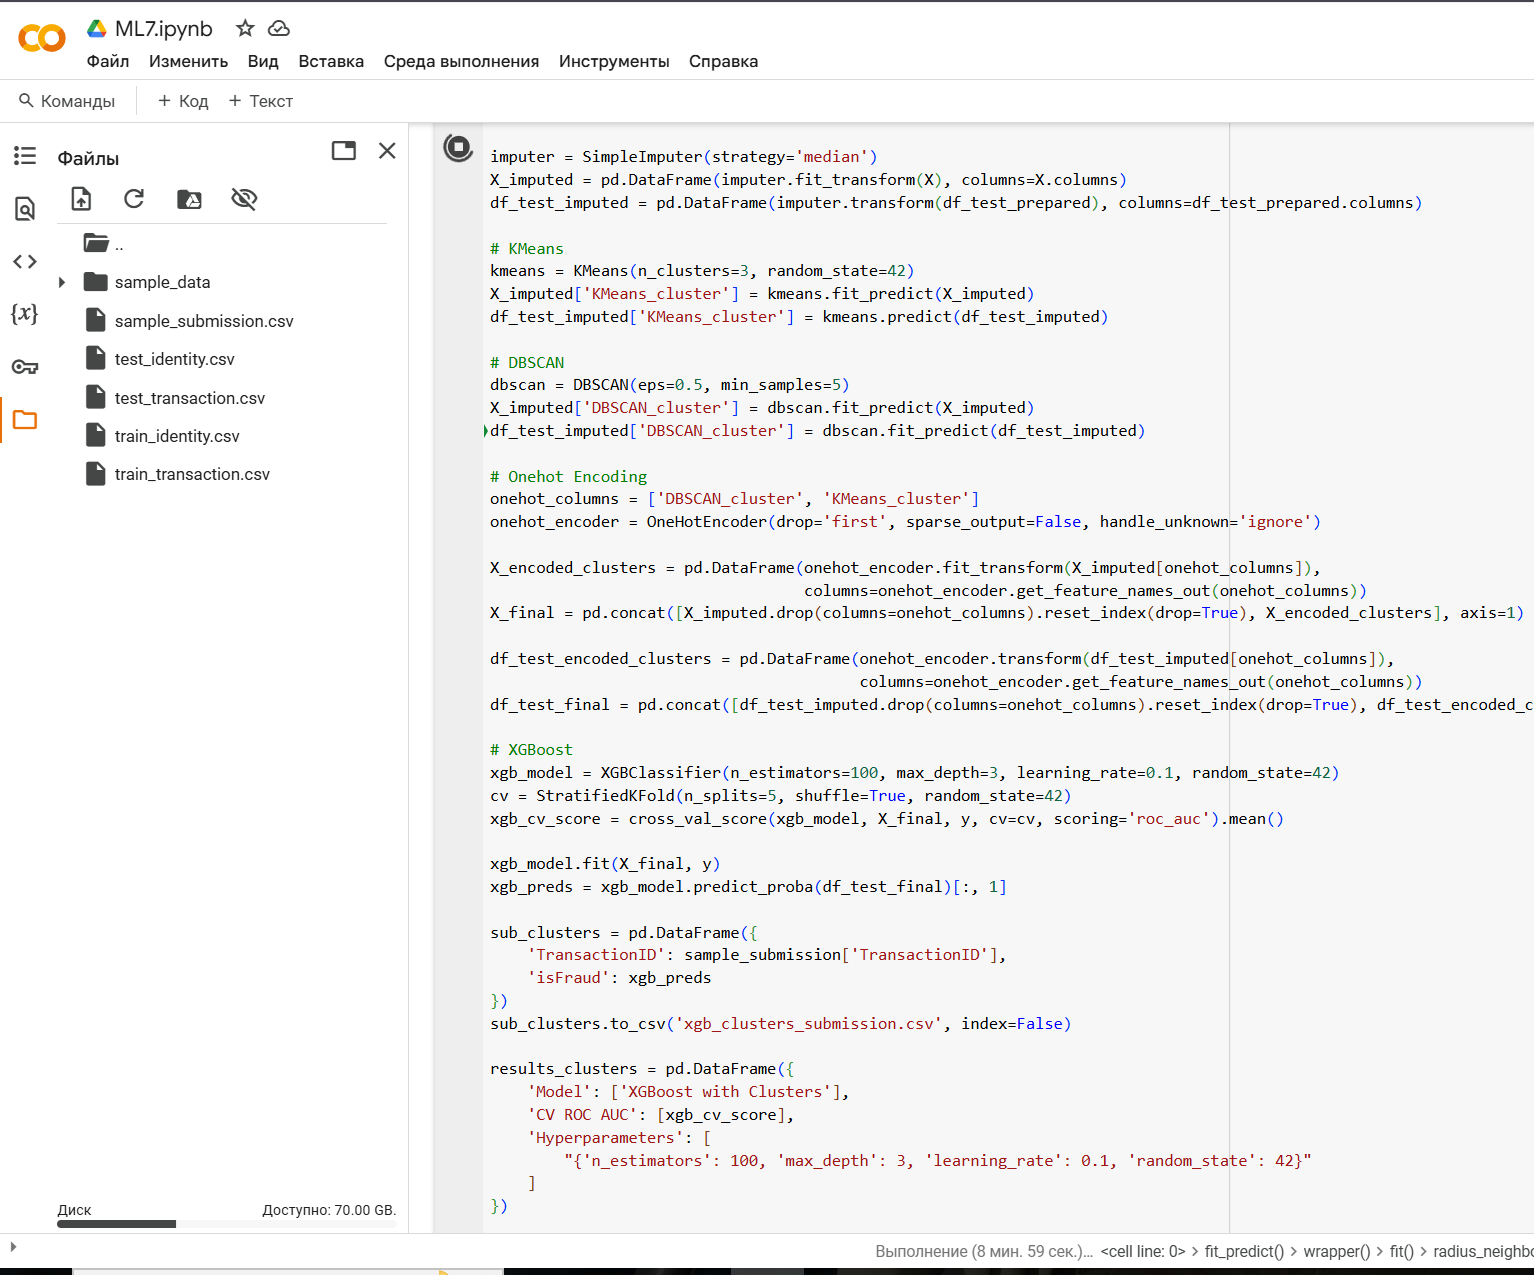

In [51]:
from IPython.display import Image
Image("image3.png", width=500, height=300)

В Google Colab мой код выполнялся более 9 минут, но так и не завершился. Честно говоря, не вижу смысла проверять Kaggle — он предоставляет чуть больше ресурсов чем колаб.
В целом, если бы у меня был слабый компьютер, я бы купил подписку на Colab за $9 в месяц. За время использования она показалась мне хорошей — прирост производительности действительно ощутимый.

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

In [ ]:
# не забудьте прикрепить скриншоты лидерборда, пожалуйста